In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from torch.distributions.multivariate_normal import MultivariateNormal

import torch.nn as nn
from pyro.distributions import Binomial, Normal
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable



from tqdm import tqdm



np.random.seed(33)

# Size

n = 90
d = 200
K = 100
p = 0.2

In [2]:
# Genarating Genotypes

toy_genotypes = np.random.binomial(2, p, (n, d))

print(toy_genotypes.shape)

(90, 200)


In [3]:
# Generating W, Z

toy_z = np.random.normal(0, 1, (n, K))
toy_w = np.random.normal(0, 1, (K, d))

toy_matrix = np.dot(toy_z, toy_w)
print(toy_matrix.shape)
print(toy_w.shape)
print(toy_z.shape)

(90, 200)
(100, 200)
(90, 100)


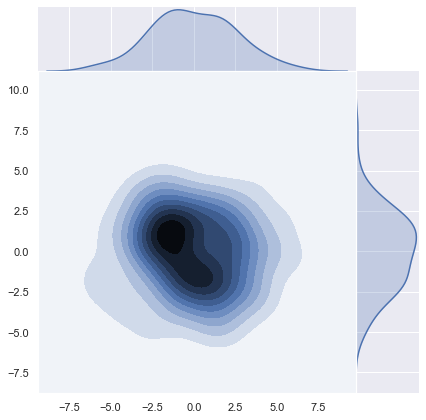

In [4]:
pca = decomposition.PCA(n_components=2)
x_std = StandardScaler().fit_transform(toy_genotypes)
component = pca.fit_transform(x_std)
component.shape

sns.jointplot(x=component[:, 0], y=component[:, 1], kind="kde", space=0)
print()

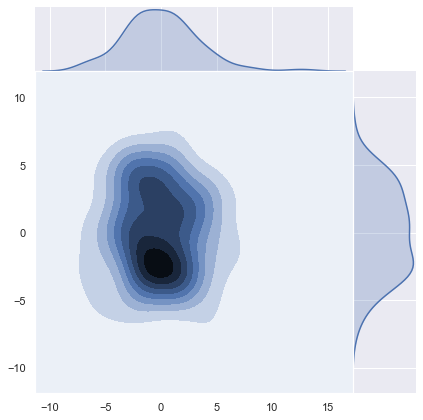

In [5]:
pca = decomposition.PCA(n_components=2)
x_std = StandardScaler().fit_transform(toy_matrix)
component = pca.fit_transform(x_std)
component.shape

sns.jointplot(x=component[:, 0], y=component[:, 1], kind="kde", space=0)
print()

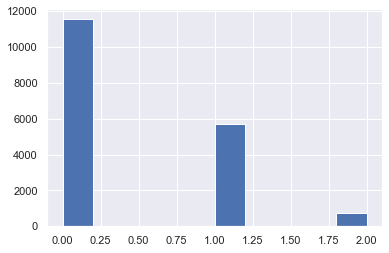

In [6]:
plt.hist(toy_genotypes.flatten())
print()

(90,)
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.]


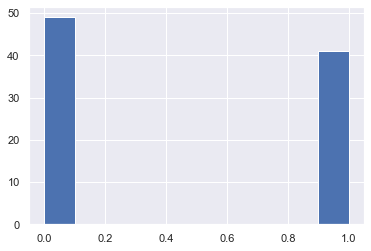

In [7]:
# Simulating phenotypes

def phen_simulator(geno_mat):
    pis=(0.9, 0.1)
    gammas=(0., 1.)
    binomial_threshold=0.
    assign = np.zeros(len(pis), dtype=np.int)
    assign[1] = 1

    mixture_assignment = {}
    betas = {}
    betas_z = {}

    std_beta = 1.


    for i in range(1):
        mixture_assignment[i] = np.repeat(np.array([assign]), 2, axis=0)    
        betas[i] = np.random.normal(loc=0.0,
                             scale=gammas[1]*std_beta,
                             size=d)
    #     betas_z[i] = np.random.normal(loc=0.0,
    #                          scale=gammas[1]*std_beta,
    #                          size=d_z) / 10


    mult = np.dot(geno_mat, betas[0])
    e = np.random.normal(0, 1, n)
    y = mult + e
    y -= y.mean()
    y /= y.std()
    y[y > 0] = 1.
    y[y <= 0] = 0.
    
    return y

toy_phenotypes = phen_simulator(toy_genotypes)
# del y, e, mult
print(toy_phenotypes.shape)
plt.hist(toy_phenotypes.flatten())
print(toy_phenotypes)

In [8]:
import numpy as np


class MF():
    
    def __init__(self, R, K, alpha, beta, iterations):
        
        self.R = R.cpu().detach().numpy()
        self.num_users, self.num_items = self.R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
#             if (i+1) % 10 == 0:
#                 print("Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            
            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :][:]
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)
    
    
mf = MF(torch.Tensor(toy_genotypes), K=K, alpha=0.1, beta=0.01, iterations=10)
training_process = mf.train()
print(mf.P.shape)
print(mf.Q.shape)


Z_fact = mf.P
W_fact = mf.Q


(90, 100)
(200, 100)


In [9]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)

    def forward(self, user, item):
        users_out = self.user_factors(user)
        items_out = self.item_factors(item)
        return (users_out * items_out).sum(1), users_out, items_out
    
model_factorization = MatrixFactorization(n, d, n_factors=K)
loss_func = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model_factorization.parameters(), lr=1e-6)  # learning rate

rows, cols = toy_genotypes.nonzero()
p = np.random.permutation(len(rows))
rows, cols = rows[p], cols[p]

for row, col in zip(*(rows, cols)):
    # Set gradients to zero
    optimizer.zero_grad()
    
    # Turn data into tensors
    rating = torch.FloatTensor([toy_genotypes[row, col]])
    row = torch.LongTensor([row])
    col = torch.LongTensor([col])

    # Predict and calculate loss
    prediction, _, _ = model_factorization(row, col)
    loss = loss_func(prediction, rating)

    # Backpropagate
    loss.backward()

    # Update the parameters
    optimizer.step()


In [10]:
class Genotype_net(nn.Module):
    
    def __init__(self, input_dim):
        super(Genotype_net, self).__init__()
        
        
        self.model = nn.Sequential(nn.Linear(input_dim, 100),
#                                    nn.ReLU(),
                                   nn.Linear(100, input_dim)
                                  )
#                                    ,
#                                    nn.LogSoftmax(dim=-1))

    
#     def forward(self, z, w, real_geno=None):
    def forward(self, out, real_geno=None):


        
#         out = torch.cat((z, w), dim=-1)
#         snps, dim = w.shape
#         N, _ = z.shape
        
        
#         w_input = torch.repeat_interleave(w[None, :, :].reshape([1, snps, dim]), N, dim=0)
#         z_input = torch.repeat_interleave(torch.reshape(z[:, None, :], [N, 1, dim]), snps, dim=1)

#         out = torch.cat([w_input, z_input], dim=2)

        N, snps = out.shape
#         print(out.shape)
#         print(self.model(out).shape)
        
        out = self.model(out).reshape(N, snps)
        
        sampled_geno = Binomial(3, logits=out).sample()
        
        
        if real_geno != None:
            loss = F.kl_div(torch.histc(real_geno) , torch.histc(sampled_geno))
            return out, sampled_geno, loss
        return out, sampled_geno
    

# geno_net = Genotype_net(d + d_z)
# geno_net.model[0].weight.shape

# pi, s = geno_net(torch.Tensor(toy_z), torch.Tensor(toy_w))
# o = torch.exp(pi).cpu().detach().numpy()
# o[o < 0.3] = 0
# o[(o >= 0.3) & (o < 0.7)] = 1
# o[(o >= 0.7) & (o < 1)] = 1
# o

In [11]:
class _Regularizer(object):
    """
    Parent class of Regularizers
    """

    def __init__(self, model):
        super(_Regularizer, self).__init__()
        self.model = model

    def regularized_param(self, param_weights, reg_loss_function):
        raise NotImplementedError

    def regularized_all_param(self, reg_loss_function):
        raise NotImplementedError
        
class GroupLassoRegularizer(_Regularizer):
    """
    GroupLasso Regularizer
    la premiere dimension représente la couche d'entrée et la deuxieme la couche de sortie
    i.e tous les poids sur la ligne représente le groupe
    groupe défini par les colonnes/lignes des matrix de W
    C'Est les colonnes qui représentent les groupes pour le weight
    """
    def __init__(self, model, lambda_reg=0.01):
        super(GroupLassoRegularizer, self).__init__(model=model)
        self.lambda_reg = lambda_reg

    def regularized_param(self, param_weights, reg_loss_function, group_name='input_group'):
        if group_name == 'input_group':
            reg_loss_function += self.lambda_reg * GroupLassoRegularizer.__inputs_groups_reg(
                        layer_weights=param_weights)  # apply the group norm on the input value
        elif group_name == 'hidden_group':
            reg_loss_function += self.lambda_reg * GroupLassoRegularizer.__inputs_groups_reg(
                        layer_weights=param_weights)  # apply the group norm on every hidden layer
        elif group_name == 'bias_group':
            reg_loss_function += self.lambda_reg * GroupLassoRegularizer.__bias_groups_reg(
                        bias_weights=param_weights)  # apply the group norm on the bias
        else:
            print(
                'The group {} is not supported yet. Please try one of this: [input_group, hidden_group, bias_group]'.format(
                    group_name))
        return reg_loss_function

    def regularized_all_param(self, reg_loss_function):
        for model_param_name, model_param_value in self.model.named_parameters():
            if model_param_name.endswith('weight'):
                reg_loss_function += self.lambda_reg * GroupLassoRegularizer.__inputs_groups_reg(
                    layer_weights=model_param_value)
            if model_param_name.endswith('bias'):
                    reg_loss_function += self.lambda_reg * GroupLassoRegularizer.__bias_groups_reg(
                        bias_weights=model_param_value)
        return reg_loss_function

    @staticmethod
    def __grouplasso_reg(groups, dim):
        if dim == -1:
            # We only have single group
            return groups.norm(2)
        return groups.norm(2, dim=dim).sum()

    @staticmethod
    def __inputs_groups_reg(layer_weights):
        return GroupLassoRegularizer.__grouplasso_reg(groups=layer_weights, dim=1)

    @staticmethod
    def __bias_groups_reg(bias_weights):
        return GroupLassoRegularizer.__grouplasso_reg(groups=bias_weights, dim=-1)  # ou 0 i dont know yet


In [12]:
# Should be pre-trained

class Phenotype_net(nn.Module):
    
    def __init__(self, input_dim):
        super(Phenotype_net, self).__init__()


        self.model_hiddens = nn.Sequential(
            nn.Linear(input_dim, 32),
#             nn.Dropout(0.5),
#             nn.ReLU(),
            nn.Linear(32, 256),
#             nn.ReLU(),
        )
        self.model = nn.Sequential(nn.Linear(256, 1))
#                                    nn.Sigmoid())



    def forward(self, x, y=None):
        
        
        
        
        N, _ = x.shape

        epsilon = Normal(loc=0.0, scale=1.0).sample(sample_shape=[N, 1])
        out = torch.cat([x, epsilon], dim=1)
        
        hiddens = self.model_hiddens(out)
#         out = torch.cat([hiddens, z], dim=1)

        out = self.model(hiddens).clone()
        
        if y is not None:
#             loss = F.mse_loss(out, y, True)
            loss = torch.mean((out - y) * (out - y)) * 0.5
            return out, hiddens, loss
        return out, hiddens
    

# phen_net = Phenotype_net((d) + K + 1, K)
# out, hiddens = phen_net(torch.Tensor(toy_genotypes), torch.Tensor(toy_z))
# print(out)


In [13]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.genotype_net = Genotype_net(d)
        self.phenotype_net = Phenotype_net(d + 1)
        
        self.groupLasso_reg = GroupLassoRegularizer(model=self.phenotype_net, lambda_reg=0.01)


        
#         self.W = None
#         self.Z = None
        
    def regularizing(self, loss):
        for model_param_name, model_param_value in self.phenotype_net.named_parameters():
            if 'model_hiddens' in model_param_name and 'weights' in model_param_name:
                loss = self.groupLasso_reg.regularized_param(param_weights=model_param_value,
                                                                          reg_loss_function=loss)
        return loss
        
    def forward(self, noise_matrix, label=None):
#         z = torch.zeros((noise_matrix.shape[0], K))
#         w = torch.zeros((K, noise_matrix.shape[1]))
#         with torch.no_grad():
            
# #             mf = MF(noise_matrix, K=100, alpha=0.1, beta=0.01, iterations=10)
# #             training_process = mf.train()

# #             z = torch.Tensor(mf.P)
# #             w = torch.Tensor(mf.Q)


#             rows, cols = noise_matrix.cpu().detach().numpy().nonzero()

#             p = np.random.permutation(len(rows))
#             rows, cols = rows[p], cols[p]
#             i = 0

#             for row, col in zip(*(rows, cols)):
#                 # Set gradients to zero
#                 optimizer.zero_grad()

#                 # Turn data into tensors
#                 row = torch.LongTensor([row])
#                 col = torch.LongTensor([col])

#                 # Predict and calculate loss
#                 ra_pr, z_r, w_r = model_factorization(row, col)

#                 z[row, :] += z_r
#                 w[:, col] += w_r.T
                
#                 i += 1.0
        
#         z = z / i
#         w = w / i
#         w = w.T
        
#         self.W = w
#         self.Z = z
        
#         print(w.shape)
#         print(z.shape)
        
        out, sampled_geno = self.genotype_net(noise_matrix.type(torch.float))
        
        if label is not None:
            return self.phenotype_net(sampled_geno, label)
            
        out, hiddens = self.phenotype_net(sampled_geno)
        
        return out, hiddens

In [14]:
class H_function(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(H_function, self).__init__()

        self.model = nn.Sequential(nn.Linear(input_size, hidden_size))
#                                    nn.ReLU())
#         self.fc2 = nn.Linear(self.hidden_size, output_size)
#         self.sigmoid = nn.ReLU()
                                  
    def forward(self, hidden, y, theta):
        out = torch.cat([hidden, y, theta], dim=1)
        out = self.model(out)
        
        # We may need a auxilary loss here!
        
        return out

In [15]:
class LogisticRegression(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
        self.activation = nn.Sigmoid()
        self.criterion = nn.BCELoss()


        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, x, y=None):
        out = self.linear(x)
        out = self.activation(out)
        
        if y is not None:
            loss = self.criterion(out, y)
            return out, loss
        
        return out

In [16]:
from scipy.stats import invgamma, norm


class Discriminator(nn.Module):
    
    def __init__(self, gen_mat):
        super(Discriminator, self).__init__()
        self.params = 128
        self.h_func = H_function(256 + 256 + self.params, 128)
        self.classifier_logistic = LogisticRegression(128)
        
        
        self.gen_mat = gen_mat



    def sampling_from_theta(self, batch_size):

        def one_sample():

            sigma_square = invgamma.rvs(np.mean(self.gen_mat), size=self.params)
            mu = np.random.normal(np.mean(self.gen_mat), self.params, size=self.params)

            uniform_dist = np.random.uniform(np.log(1), np.log(n), self.params)

            # plt.hist(sigma_square)
            # plt.show()
            # plt.hist(uniform_dist)
            # plt.show()

            weights = np.exp(uniform_dist)
            pi_dist = y = np.fromiter((norm.rvs(mu[i], sigma_square[i]) for i in range(self.params)), dtype=np.float64)

            xs = np.linspace(y.min(), y.max(), self.params)
            ys = np.zeros_like(xs)

            for i in range(self.params):
                ys += norm.pdf(xs, loc=mu[i], scale=sigma_square[i]) * weights[i]

            return np.array(ys)

        samples = one_sample()[None,:]
        for i in range(batch_size - 1):
            samples = np.concatenate([samples, one_sample()[None,:]], axis=0)

        return torch.Tensor(samples)
    
    def forward(self, hidden, y, label=None):
        b, _ = hidden.shape
        theta = self.sampling_from_theta(b)
        
        out = self.h_func(hidden, torch.repeat_interleave(y, hidden.shape[-1], dim=-1), theta)
        return self.classifier_logistic(out, label)
        
        
        

In [17]:
class Loader(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, genotype_matrix, phenotypes, synthetic_genotypes=None, synthetic_phenotypes=None, transform=None, batch_size=1):

        self.phenotypes = phenotypes
        self.genotype_matrix = genotype_matrix
        self.synthetic_genotypes = synthetic_genotypes
        self.synthetic_phenotypes = synthetic_phenotypes
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return len(self.genotype_matrix)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        real_samples = self.genotype_matrix[idx, ]
        if self.synthetic_genotypes is not None:
            synthetic_samples = self.synthetic_genotypes[idx, ]
            samples = np.stack((real_samples, synthetic_samples), axis=1)
            identity = np.array([1, 0]) # 1: real , 0: fake
            labels = np.array([self.phenotypes[idx, ], self.synthetic_phenotypes[idx, ]])
            batch = {'samples': samples.T, 'labels': labels, 'identity': identity}


        else:
            samples = real_samples
            labels = self.phenotypes[idx, ]
            batch = {'samples': samples, 'labels': labels}


        if self.transform:
            batch = self.transform(batch)

        return batch

    
    
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data    

# dataset = Loader(toy_genotypes, toy_phenotypes, toy_matrix, toy_phenotypes)
dataset = Loader(toy_genotypes, toy_phenotypes)

BATCH_SIZE = 4
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# for batch_ndx, sample in enumerate(loader):
# #     print(sample['samples'][0][1])
# #     print(sample['identity'][0][1])
#     print(sample)

#     break

In [18]:
from torch import optim

discriminator = Discriminator(toy_genotypes)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
# g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

def train_discriminator(optimizer, real_data, fake_data):
    N = real_data['phenotype'].size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    prediction_real, error_real = discriminator(real_data['hidden'], real_data['phenotype'], label=ones_target(N))
    error_real.backward()


    prediction_fake, error_fake = discriminator(fake_data['hidden'], fake_data['phenotype'], label=zeros_target(N))
    error_fake.backward()
    
    optimizer.step()

    return error_real + error_fake, prediction_real, prediction_fake

In [19]:
generator = Generator()

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)


def train_generator(optimizer, fake_data):
    
    N = fake_data['hidden'].size(0)

    optimizer.zero_grad()

    prediction, error = discriminator(fake_data['hidden'], fake_data['phenotype'], label=ones_target(N))
    
    error = generator.regularizing(error)

    error.backward()

    optimizer.step()

    return error

In [20]:
from torch.autograd.variable import Variable

def noise(size):

    n = Variable(torch.randn(size))
    return n

num_epochs = 80

denum = n / BATCH_SIZE

losses = []

for epoch in tqdm(range(num_epochs)):
    d_error_sum = 0
    g_error_sum = 0
    for n_batch, batch in enumerate(data_loader):
        N = batch['samples'].size(0)
        
        # 1. Train Discriminator
        real_data_sample = batch['samples']

        # Generate fake data and detach 
        # (so gradients are not calculated for generator)

        fake_phenotype, fake_hiddens = generator(noise((real_data_sample.shape[0], real_data_sample.shape[1])))
        fake_phenotype = fake_phenotype.detach()

        fake_phenotype[fake_phenotype < 0.5] = 0
        fake_phenotype[fake_phenotype >= 0.5] = 1
        
        fake_hiddens = fake_hiddens.detach()
        
        real_phenotype, real_hiddens, loss_aux = generator(real_data_sample, batch['labels'])
        real_phenotype = real_phenotype.detach()

        real_phenotype[real_phenotype < 0.5] = 0
        real_phenotype[real_phenotype >= 0.5] = 1

        real_hiddens = real_hiddens.detach()
        
        real_data = {'hidden': real_hiddens, 'phenotype': real_phenotype}
        fake_data = {'hidden': fake_hiddens, 'phenotype': fake_phenotype}


        
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)
        
        loss_aux.backward()
        

        # 2. Train Generator
        # Generate fake data
        fake_phenotype, fake_hiddens = generator(noise((real_data_sample.shape[0], real_data_sample.shape[1])))
        
        fake_phenotype[fake_phenotype < 0.5] = 0
        fake_phenotype[fake_phenotype >= 0.5] = 1
    
        fake_data = {'hidden': fake_hiddens, 'phenotype': fake_phenotype}


        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        
        d_error_sum += d_error
        g_error_sum += g_error
        
        
        
    losses.append([d_error_sum / denum, g_error_sum / denum])
#         # Display Progress every few batches
#         if (n_batch) % 100 == 0: 
#             test_images = vectors_to_images(generator(test_noise))
#             test_images = test_images.data
#             logger.log_images(
#                 test_images, num_test_samples, 
#                 epoch, n_batch, num_batches
#             );
#             # Display status Logs
#             logger.display_status(
#                 epoch, num_epochs, n_batch, num_batches,
#                 d_error, g_error, d_pred_real, d_pred_fake
#             )

    


100%|██████████| 80/80 [08:43<00:00,  6.54s/it]


In [21]:
errors_g = [0 for i in range(len(losses))]
errors_d = [0 for i in range(len(losses))]

for i in range(len(losses)):
    errors_d[i] = losses[i][0]
    errors_g[i] = losses[i][1]

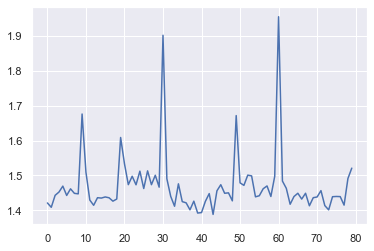

In [22]:
plt.plot(np.arange(epoch + 1), errors_d)

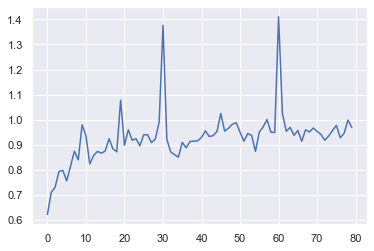

In [23]:
plt.plot(errors_g)

In [24]:
test_genotypes = np.random.binomial(2, 0.2, (n, d))


test_phenotypes = phen_simulator(test_genotypes)

print(test_phenotypes.shape)
print(test_genotypes.shape)

(90,)
(90, 200)


In [25]:
generator.eval()
preditions = []
for i in range(test_genotypes.shape[0]):
    single_sample = torch.tensor(test_genotypes[i, :][None, :])
    single_sample_label = test_phenotypes[i]
    
    
    single_phenotype_pred, single_hidden_pred = generator(single_sample)
    
    single_phenotype_pred[single_phenotype_pred < 0.5] = 0
    single_phenotype_pred[single_phenotype_pred >= 0.5] = 1
    single_phenotype_pred = single_phenotype_pred[0]
    
    
    preditions += [float(single_phenotype_pred)]
    
    

In [26]:
preditions = np.array(preditions)
wrong_preds = np.sum(np.abs(preditions - test_phenotypes))

print('Accuracy', (n - wrong_preds) / n * 100, '%')

Accuracy 47.77777777777778 %
